In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

import warnings
warnings.filterwarnings('ignore')

In [2]:
%cd ~/PycharmProjects/pqr/
import pqr

/home/akbabkin/PycharmProjects/pqr


## Считываем данные

In [3]:
prices = pd.read_excel('/home/akbabkin/notebooks/summer_school/data/price.xlsx', index_col=0, parse_dates=True)
index = pd.read_excel('/home/akbabkin/notebooks/summer_school/data/benchmark.xlsx', index_col=0, parse_dates=True)['CLOSE']
index.name = 'FTSE_MIB'


pe = pd.read_excel('/home/akbabkin/notebooks/summer_school/data/mults/pe.xlsx', index_col=0, parse_dates=True)
mcap = pd.read_excel('/home/akbabkin/notebooks/summer_school/data/financials/market_cap.xlsx', index_col=0, parse_dates=True)
volume = pd.read_excel('/home/akbabkin/notebooks/summer_school/data/liquidity/volume.xlsx', index_col=0, parse_dates=True)

In [4]:
# корректируем матрицы (сортировка + удаление лишних колонок и индексов)
prices, pe, mcap, volume = pqr.correct_matrices(prices, pe, mcap, volume)

## Создаем на основе данных факторы

In [5]:
# основной фактор на основе P/E
value = pqr.factorize(pe, looking_period=3, lag_period=0, holding_period=3)

# фильтрующий фактор на основе среднедневного объема (те же параметры, что и для основного + пороги)
liquidity = pqr.factorize(volume, looking_period=1)
liquidity_thresholds = pqr.Thresholds(lower=2_000_000)

# взвешивающий фактор на основе капитализации
size_w = pqr.factorize(mcap, looking_period=1)

# бенчмарк уже готовый
benchmark = pqr.benchmark_from_index(index)

## "Обучаем" факторную модель.

In [6]:
portfolios = pqr.fit_factor_model(
    stock_prices=prices,
    factor=value,
    filtering_factor=liquidity,
    filtering_thresholds=liquidity_thresholds,
    weighting_factor=size_w,
    n_quantiles=3,
    add_wml=True,
    is_bigger_better=True
)

## После обучения у факторной модели появились портфели. С ними можно работать по отдельности

In [7]:
portfolios[0].returns

2016-04-30    0.000000
2016-05-31   -0.069600
2016-06-30   -0.184336
2016-07-31    0.129370
2016-08-31   -0.018431
                ...   
2020-12-31   -0.010402
2021-01-31   -0.047908
2021-02-28    0.169501
2021-03-31    0.095281
2021-04-30   -0.000129
Length: 61, dtype: float64

In [8]:
pqr.alpha(portfolios[0], benchmark)

-0.005276794077400717

In [9]:
pqr.rolling_alpha(portfolios[0], benchmark)

2016-04-30         NaN
2016-05-31         NaN
2016-06-30         NaN
2016-07-31         NaN
2016-08-31         NaN
                ...   
2020-12-31   -0.010493
2021-01-31   -0.007771
2021-02-28   -0.004354
2021-03-31   -0.014106
2021-04-30   -0.004245
Length: 61, dtype: float64

In [10]:
pqr.rolling_sharpe(portfolios[0])

2016-04-30         NaN
2016-05-31         NaN
2016-06-30         NaN
2016-07-31         NaN
2016-08-31         NaN
                ...   
2020-12-31   -0.236303
2021-01-31   -0.214607
2021-02-28    0.171837
2021-03-31    1.118732
2021-04-30    1.180742
Length: 61, dtype: float64

In [11]:
pqr.max_drawdown(portfolios[0])

-0.5000636561559835

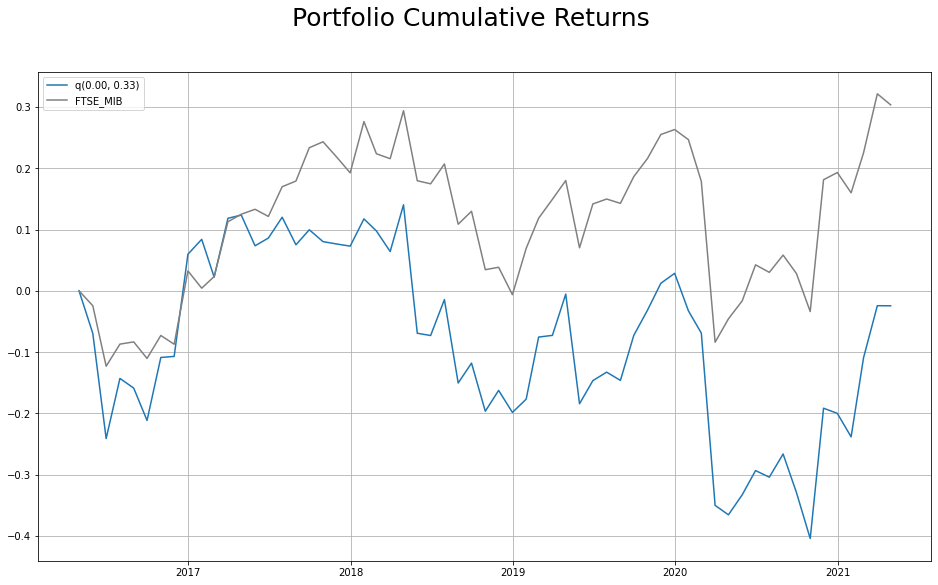

In [12]:
pqr.plot_cumulative_returns(portfolios[0], benchmark=benchmark)

## Сравниваем портфели 
tabulate пришлось убрать, поскольку при отрисовке больше 3 портфелей у меня слетало форматирование из-за того, что вывод не помещался. Пока временно сделал табличку с помощью пандаса

,"q(0.00, 0.33)","q(0.33, 0.67)","q(0.67, 1.00)",wml_portfolio
"Alpha, %",-0.53,0.03,0.17,0.70
Beta,1.43,1.02,0.82,-0.61
Sharpe Ratio,0.15,0.35,0.42,0.15
"Mean Return, %",0.43,0.71,0.72,0.29
"Mean Excessive Return, %",-0.18,0.11,0.11,-0.32
"Volatility, %",9.73,7.03,5.91,6.91
Benchmark Correlation,0.91,0.90,0.86,-0.55
"Profitable Periods, %",50.82,59.02,49.18,57.38
"Maximum Drawdown, %",-50.01,-37.28,-24.50,-38.28


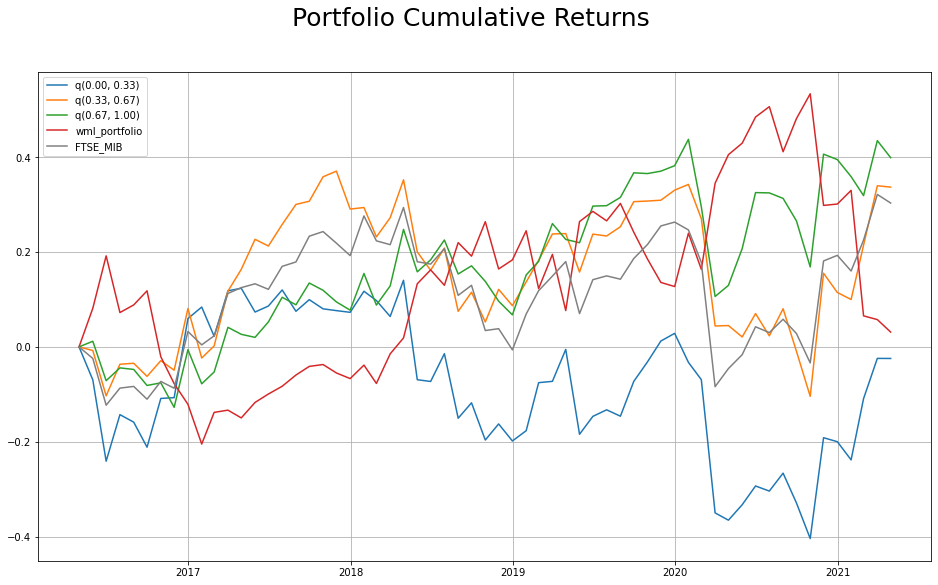

In [13]:
pqr.plot_cumulative_returns(*portfolios, benchmark=benchmark)
pqr.compare_portfolios(*portfolios, benchmark=benchmark)

## grid_search
Функция из модуля factor_model - принимает на вход сначала 3 списка/массива/чего угодно, по чему можно итерироваться; дальше все параметры повторяют параметры метода fit(). Возвращает словарь, в котором ключ - кортеж вида (1, 0, 1) - это, соответственно, looking_period, lag_period, holding_period, а значение - датафрейм с результатами (такой же, как и в compare_portfolios()). 

In [14]:
%%time
%%capture

results = pqr.grid_search(
    prices,
    pe,
    is_dynamic=False,
    looking_periods=[1, 3, 6, 9, 12],
    lag_periods=[0, 1],
    holding_periods=[1, 3, 6, 9, 12],
    filtering_factor=liquidity,
    filtering_thresholds=liquidity_thresholds,
    weighting_factor=size_w,
    benchmark=benchmark
)

CPU times: user 2.47 s, sys: 16.4 ms, total: 2.49 s
Wall time: 2.5 s


In [15]:
results[(1, 0, 1)]

,"q(0.00, 0.33)","q(0.33, 0.67)","q(0.67, 1.00)"
"Alpha, %",-0.63,0.03,0.27
Beta,1.52,0.95,0.80
Sharpe Ratio,0.10,0.31,0.45
"Mean Return, %",0.29,0.61,0.76
"Mean Excessive Return, %",-0.31,-0.00,0.16
"Volatility, %",10.15,6.69,5.88
Benchmark Correlation,0.92,0.87,0.84
"Profitable Periods, %",47.62,50.79,55.56
"Maximum Drawdown, %",-60.99,-36.95,-24.19


In [16]:
results[(12, 0, 12)]

,"q(0.00, 0.33)","q(0.33, 0.67)","q(0.67, 1.00)"
"Alpha, %",-0.17,0.37,-0.35
Beta,1.38,0.96,0.83
Sharpe Ratio,0.27,0.50,0.10
"Mean Return, %",0.72,0.99,0.18
"Mean Excessive Return, %",0.11,0.38,-0.42
"Volatility, %",9.32,6.81,6.10
Benchmark Correlation,0.92,0.88,0.85
"Profitable Periods, %",55.77,59.62,51.92
"Maximum Drawdown, %",-55.01,-40.03,-36.83


# random_test

In [17]:
best_portfolio = portfolios[2]

In [18]:
%%time
%%capture

target_values, random_portfolios = pqr.random_test(prices, best_portfolio, pqr.sharpe, n=1000)

CPU times: user 5.53 s, sys: 14.1 ms, total: 5.54 s
Wall time: 5.56 s


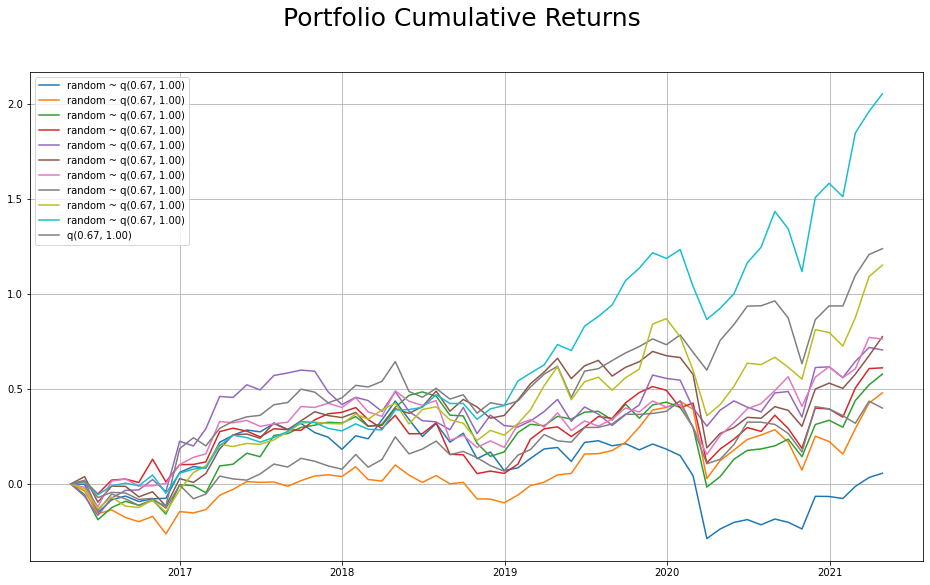

In [19]:
pqr.plot_cumulative_returns(*random_portfolios, benchmark=best_portfolio)